<h1>Spotify Track Popularity based on Audio Features</h1>

<h2>Setup & Imports</h2>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

<h2>Load Data</h2>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2>Basic Cleaning + Preprocessing</h2>

In [ ]:
# Load Data
df = pd.read_csv("dataset.csv")

# Quick info
df.info()

# Check for missing values
df.isna().sum()

# Drop duplicate tracks by track_id (if any)
df = df.drop_duplicates(subset="track_id").reset_index(drop=True)
print("Shape after dropping duplicate track_id:", df.shape)

# Convert 'explicit' from TRUE/FALSE string to 0/1 if needed
if df['explicit'].dtype == 'object':
    df['explicit'] = df['explicit'].map({'TRUE': 1, 'True': 1, 'FALSE': 0, 'False': 0})

df['explicit'] = df['explicit'].astype(int)

# Just to be safe: drop rows where popularity is missing
df = df.dropna(subset=['popularity'])
print("Shape after ensuring popularity is not missing:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

<h2>Exploratory Data Analysis</h2>

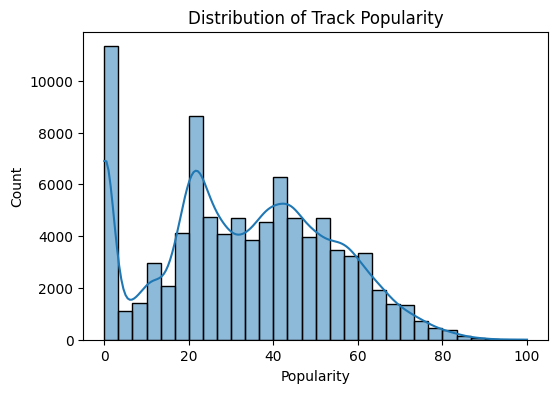

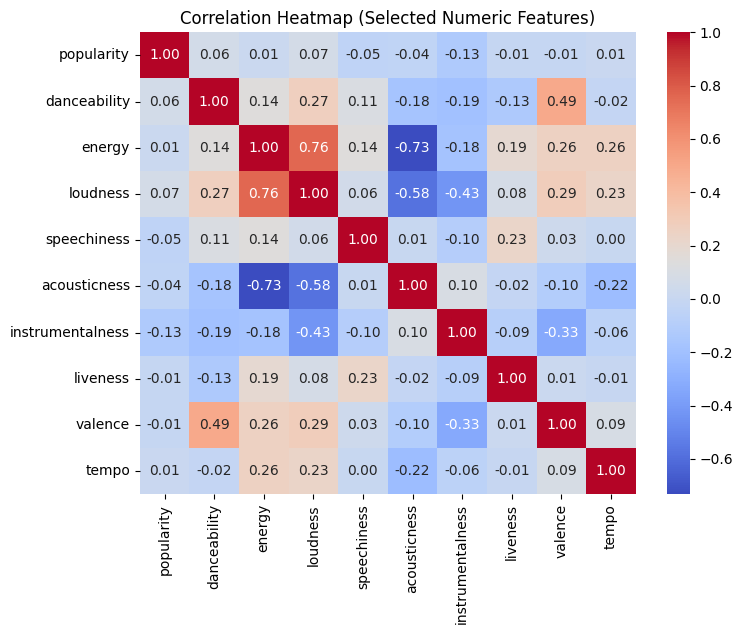

70th percentile popularity threshold: 45.0
pop_label
0    0.686052
1    0.313948
Name: proportion, dtype: float64


,popularity,danceability,energy,valence,tempo
track_genre,,,,,
k-pop,59.358779,0.641629,0.682687,0.569141,119.550896
pop-film,59.096933,0.591431,0.599897,0.528520,116.953353
metal,56.422414,0.481177,0.841392,0.424929,129.479871
chill,53.738683,0.666423,0.429531,0.408306,115.383460
latino,51.788945,0.755487,0.712343,0.622474,121.420261
sad,51.109929,0.701801,0.478868,0.439608,119.359216
grunge,50.587007,0.455414,0.804870,0.400566,129.985355
indian,49.765348,0.585930,0.554673,0.448285,115.207430
anime,48.776884,0.537666,0.674229,0.434644,123.607734


In [ ]:
# Distribution of popularity
# Creates a historgram of the popularity column, and how many tracks are at varying levels of populairty
# Adds a KDE (Kernel Density Estimation) curve to visualize the density, helping to identify trends
plt.figure(figsize=(6,4))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

# Correlation heatmap for key numeric features
# Identify linear relationships between audio features and populairty
# Shows feature intereactions

# Select 10 key features + popularity
num_cols_for_corr = [
    'popularity', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Compute pairwise correlations
corr = df[num_cols_for_corr].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Selected Numeric Features)")
plt.show()

# Popular vs. less popular tracks summary
# Defines popular as the top 30% of tracks
# Enables classification model and reflects on Spotify's real world distribution (few songs go viral)
popularity_threshold = df['popularity'].quantile(0.70)  # top 30% as "popular"
print("70th percentile popularity threshold:", popularity_threshold)

# Create a new binary label, 1 = popular, 0 = not popular
df['pop_label'] = (df['popularity'] >= popularity_threshold).astype(int)

print(df['pop_label'].value_counts(normalize=True))
# Expect lower correlations as popularity depends on many external factors (marketing, playlist placement), not just audio attributes

# Genre-level summary (for a subset of genres)
# Popularity should vary by genre
genre_summary = (
    df.groupby('track_genre')[['popularity', 'danceability', 'energy', 'valence', 'tempo']]
      .mean() # mean captures typical feature values and aligns with regression assumptions, EDA standard
      .sort_values('popularity', ascending=False)
      .head(15)
)

genre_summary

<h2>Feature Engineering</h2> <p>

In [ ]:
# Decides which columns as inputs

# Target variables
target_reg = 'popularity' # regression target, pop score
target_clf = 'pop_label' # classification target, 1 = pop, 0 = not pop

# Numeric input features
# doesn't need encoding
numeric_features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo', 'duration_ms'
]

# Categorical features
# needs encoding because models would otherwise misinterpret
categorical_features = ['track_genre', 'key', 'mode', 'time_signature', 'explicit']

# Keep only rows without missing in these columns
# dropping rows with missing avoids having to define missing values, esp in large dataset
use_cols = [target_reg, target_clf] + numeric_features + categorical_features
df_model = df[use_cols].dropna().reset_index(drop=True) # reset index avoids confusing gaps
print("Shape after selecting modeling columns:", df_model.shape)

# One-hot encode categorical features
df_model_encoded = pd.get_dummies(df_model, columns=categorical_features, drop_first=True) # drop to avoid dummy variable trap where one category becomes baseline

print("Shape after one-hot encoding:", df_model_encoded.shape)
df_model_encoded.head()

Shape after selecting modeling columns: (89741, 17)
Shape after one-hot encoding: (89741, 141)


,popularity,pop_label,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,key_8,key_9,key_10,key_11,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5,explicit_1
0,73,1,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,...,False,False,False,False,False,False,False,True,False,False
1,55,1,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,...,False,False,False,False,True,False,False,True,False,False
2,57,1,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,...,False,False,False,False,True,False,False,True,False,False
3,71,1,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,...,False,False,False,False,True,False,True,False,False,False
4,82,1,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,...,False,False,False,False,True,False,False,True,False,False


<h2>Train/Validation/Test Split + Scaling</h2>

In [ ]:
# Separate features (X) and targets (y)
X = df_model_encoded.drop(columns=[target_reg, target_clf])
y_reg = df_model_encoded[target_reg]
y_clf = df_model_encoded[target_clf]

# Train / test split (we'll also carve out validation from train if needed)
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("Train shape:", X_train.shape)
print("Test shape: ", X_test.shape)

# Scale numeric columns only (we stored their original names before dummies)
scaler = StandardScaler()

# Index of numeric columns in the encoded dataframe
numeric_cols_in_encoded = [col for col in X_train.columns if col in numeric_features]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols_in_encoded] = scaler.fit_transform(X_train[numeric_cols_in_encoded])
X_test_scaled[numeric_cols_in_encoded] = scaler.transform(X_test[numeric_cols_in_encoded])

Train shape: (71792, 139)
Test shape:  (17949, 139)


<h2>Regression Models</h2>
<p>
We'll train:
<ul>
<li> Linear Regression </li>
<li> Ridge </li>
<li> Lasso </li>
<li> Random Forest Regressor </li>
</ul>
and compare RMSE, MAE, R².

In [ ]:
regression_results = []
# train and score
def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
  #  number of rows and features model is training on
    print(f"Training {name} on {X_train.shape[0]} samples and {X_train.shape[1]} features...")
    model.fit(X_train, y_train) #train model
    print(f"Done training {name}. Predicting on test set...")
    y_pred = model.predict(X_test)
# compute evalutation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) #large mistakes
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

# save metrics
    regression_results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })
    print(f"{name} results -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}\n")

# Linear Regression, standard least squares linear model
lin_reg = LinearRegression()
evaluate_regression_model(
    "Linear Regression",
    lin_reg,
    X_train_scaled, y_reg_train,
    X_test_scaled, y_reg_test
)

# Ridge Regression
# linear but w L2 regularization, to prevent overfitting for correlated features
ridge_reg = Ridge(alpha=1.0, random_state=42)
evaluate_regression_model(
    "Ridge (alpha=1.0)",
    ridge_reg,
    X_train_scaled, y_reg_train,
    X_test_scaled, y_reg_test
)

# Lasso Regression L1 regularization
lasso_reg = Lasso(alpha=0.1, random_state=42, max_iter=10000)
evaluate_regression_model(
    "Lasso (alpha=0.1)",
    lasso_reg,
    X_train_scaled, y_reg_train,
    X_test_scaled, y_reg_test
)

# Random Forest Regression
#   - train on a subset of the training data
#   - fewer trees + limited depth so it doesn't take forever

# Use at most 20,000 training rows for RF to keep it fast
n_rf_train = min(20000, X_train_scaled.shape[0])
X_train_rf = X_train_scaled.sample(n=n_rf_train, random_state=42)
y_reg_train_rf = y_reg_train.loc[X_train_rf.index]

rf_reg = RandomForestRegressor(
    n_estimators=50,      # fewer trees than 200
    max_depth=20,        # limit tree depth
    min_samples_leaf=5,  # avoid tiny leaves
    random_state=42,
    n_jobs=-1
)

evaluate_regression_model(
    "Random Forest Regressor (fast)",
    rf_reg,
    X_train_rf, y_reg_train_rf,
    X_test_scaled, y_reg_test
)

# Show results as a sorted table
regression_results_df = pd.DataFrame(regression_results).sort_values("RMSE")
regression_results_df

Training Linear Regression on 71792 samples and 139 features...
Done training Linear Regression. Predicting on test set...
Linear Regression results -> RMSE: 16.860, MAE: 12.029, R2: 0.327

Training Ridge (alpha=1.0) on 71792 samples and 139 features...
Done training Ridge (alpha=1.0). Predicting on test set...
Ridge (alpha=1.0) results -> RMSE: 16.860, MAE: 12.035, R2: 0.327

Training Lasso (alpha=0.1) on 71792 samples and 139 features...
Done training Lasso (alpha=0.1). Predicting on test set...
Lasso (alpha=0.1) results -> RMSE: 18.555, MAE: 15.023, R2: 0.184

Training Random Forest Regressor (fast) on 20000 samples and 139 features...
Done training Random Forest Regressor (fast). Predicting on test set...
Random Forest Regressor (fast) results -> RMSE: 17.910, MAE: 13.832, R2: 0.240



,Model,RMSE,MAE,R2
0,Linear Regression,16.859739,12.029411,0.326653
1,Ridge (alpha=1.0),16.859905,12.034881,0.326640
3,Random Forest Regressor (fast),17.909901,13.832112,0.240157
2,Lasso (alpha=0.1),18.555319,15.022649,0.184406


<h2>Classification Models</h2>
<p>
We'll compare:
<ul>
<li> Logistic Regression </li>
<li> Decision Tree </li>
<li> Random Forest </li>
<li> KNN </li>
using Accuracy, Precision, Recall, F1, ROC-AUC.

In [ ]:

classification_results = []

def evaluate_classification_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Some models (e.g., SVM) don't have predict_proba, but our choices do.
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba)

    classification_results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": roc
    })

    return model, y_pred, y_proba

# Logistic Regression
log_reg_clf = LogisticRegression(max_iter=500, n_jobs=-1)
log_reg_clf, log_y_pred, log_y_proba = evaluate_classification_model(
    "Logistic Regression",
    log_reg_clf,
    X_train_scaled, y_clf_train,
    X_test_scaled, y_clf_test
)

# Decision Tree
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_clf, dt_y_pred, dt_y_proba = evaluate_classification_model(
    "Decision Tree",
    dt_clf,
    X_train_scaled, y_clf_train,
    X_test_scaled, y_clf_test
)

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf, rf_y_pred, rf_y_proba = evaluate_classification_model(
    "Random Forest",
    rf_clf,
    X_train_scaled, y_clf_train,
    X_test_scaled, y_clf_test
)

# KNN
knn_clf = KNeighborsClassifier(n_neighbors=15)
knn_clf, knn_y_pred, knn_y_proba = evaluate_classification_model(
    "KNN (k=15)",
    knn_clf,
    X_train_scaled, y_clf_train,
    X_test_scaled, y_clf_test
)

classification_results_df = pd.DataFrame(classification_results).sort_values("ROC-AUC", ascending=False)
classification_results_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
2,Random Forest,0.801270,0.757727,0.539485,0.630248,0.867971
0,Logistic Regression,0.772856,0.679328,0.523691,0.591442,0.829479
3,KNN (k=15),0.750682,0.641188,0.467436,0.540696,0.793298
1,Decision Tree,0.740988,0.806592,0.230169,0.358139,0.601306


<h2>Confusion Matrix + ROC for Best Classifier</h2>

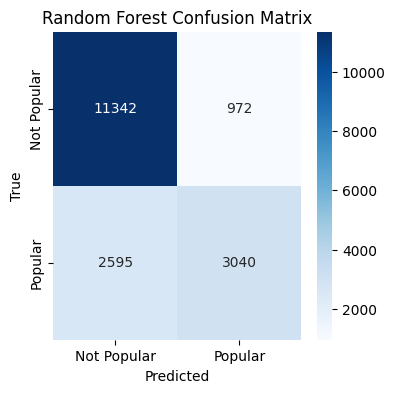

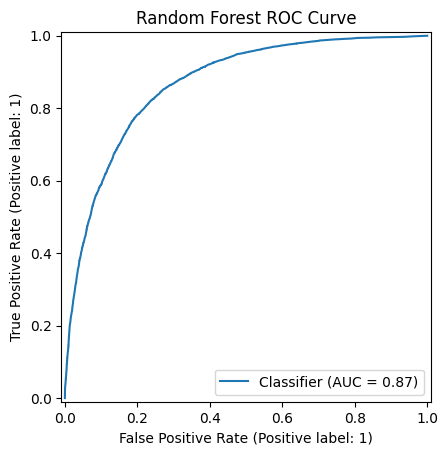

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_clf_test, rf_y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Popular', 'Popular'],
            yticklabels=['Not Popular', 'Popular'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_clf_test, rf_y_proba)
plt.title("Random Forest ROC Curve")
plt.show()

<h2>Feature Importance </h2>
<p>

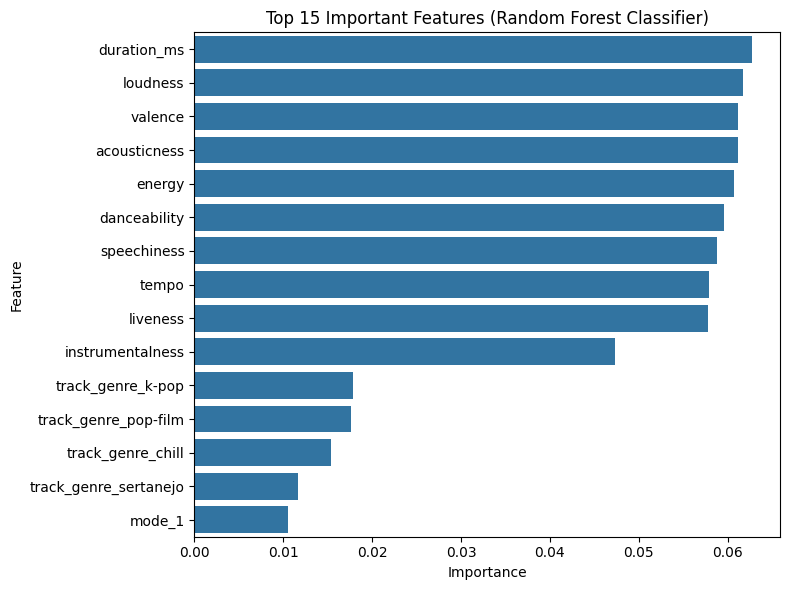

,feature,importance
9,duration_ms,0.062749
2,loudness,0.061677
7,valence,0.061203
4,acousticness,0.061188
1,energy,0.060701
0,danceability,0.059603
3,speechiness,0.058757
8,tempo,0.057945
6,liveness,0.057769
5,instrumentalness,0.047317


In [ ]:

importances = rf_clf.feature_importances_
feature_names = X_train_scaled.columns

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

top_n = 15
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp.head(top_n), x="importance", y="feature")
plt.title(f"Top {top_n} Important Features (Random Forest Classifier)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

feat_imp.head(20)

<h2>Summary</h2>

In [ ]:
print("Regression Models Summary")
print(regression_results_df.to_string(index=False))

print("\nClassification Models Summary")
print(classification_results_df.to_string(index=False))

print("\nTop 10 Most Important Features (Random Forest Classifier):")
print(feat_imp.head(10).to_string(index=False))

===== Regression Models Summary =====
                         Model      RMSE       MAE       R2
             Linear Regression 16.859739 12.029411 0.326653
             Ridge (alpha=1.0) 16.859905 12.034881 0.326640
Random Forest Regressor (fast) 17.909901 13.832112 0.240157
             Lasso (alpha=0.1) 18.555319 15.022649 0.184406

===== Classification Models Summary =====
              Model  Accuracy  Precision   Recall       F1  ROC-AUC
      Random Forest  0.801270   0.757727 0.539485 0.630248 0.867971
Logistic Regression  0.772856   0.679328 0.523691 0.591442 0.829479
         KNN (k=15)  0.750682   0.641188 0.467436 0.540696 0.793298
      Decision Tree  0.740988   0.806592 0.230169 0.358139 0.601306

Top 10 Most Important Features (Random Forest Classifier):
         feature  importance
     duration_ms    0.062749
        loudness    0.061677
         valence    0.061203
    acousticness    0.061188
          energy    0.060701
    danceability    0.059603
     speechiness